# ML based model to assess patient’s individual risk of postoperative mortality based on preoperative data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from sklearn.model_selection import (GridSearchCV,StratifiedKFold,
                                     train_test_split)
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import (log_loss,confusion_matrix,
                             classification_report,
                             ConfusionMatrixDisplay,roc_curve,accuracy_score)
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression 
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
import plotly.offline as pyo
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

# loading the data

In [2]:
df=pd.read_csv(r"C:\Users\ghild\OneDrive\Desktop\CDAC_PROJECT\clinical_data.csv")
df.head()

#Using list(df) to get the list of all Column Names
column_headers = list(df)
print(column_headers)

['case_id', 'subjectid', 'casestart', 'caseend', 'anestart', 'aneend', 'opstart', 'opend', 'adm', 'dis', 'icu_days', 'death_inhosp', 'age', 'sex', 'height', 'weight', 'bmi', 'asa', 'emop', 'department', 'optype', 'dx', 'opname', 'approach', 'position', 'ane_type', 'preop_htn', 'preop_dm', 'preop_ecg', 'preop_pft', 'preop_hb', 'preop_plt', 'preop_pt', 'preop_aptt', 'preop_na', 'preop_k', 'preop_gluc', 'preop_alb', 'preop_ast', 'preop_alt', 'preop_bun', 'preop_cr', 'preop_ph', 'preop_hco3', 'preop_be', 'preop_pao2', 'preop_paco2', 'preop_sao2', 'cormack', 'airway', 'tubesize', 'dltubesize', 'lmasize', 'iv1', 'iv2', 'aline1', 'aline2', 'cline1', 'cline2', 'intraop_ebl', 'intraop_uo', 'intraop_rbc', 'intraop_ffp', 'intraop_crystalloid', 'intraop_colloid', 'intraop_ppf', 'intraop_mdz', 'intraop_ftn', 'intraop_rocu', 'intraop_vecu', 'intraop_eph', 'intraop_phe', 'intraop_epi', 'intraop_ca']


In [3]:
#total number of records
print(df.shape) #6388

(6388, 74)


In [4]:
#as our aim is to assess patient’s individual risk of postoperative mortality based on preoperative data
#selecting only relevant columns
preop_df=df[['case_id','emop','dx','death_inhosp','adm','icu_days', 'age', 'bmi', 'asa','sex','department','optype','ane_type'
       ,'preop_htn', 'preop_dm', 'preop_ecg', 'preop_pft', 'preop_hb',
       'preop_plt', 'preop_pt', 'preop_aptt', 'preop_na', 'preop_k',
       'preop_gluc', 'preop_alb', 'preop_ast', 'preop_alt', 'preop_bun',
       'preop_cr']]

# Excluding underage patients  and emergency patients

In [5]:

print(preop_df.info())

pd.set_option('display.max_columns', None)# as age column is not displaying
print(preop_df['age'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6388 entries, 0 to 6387
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   case_id       6388 non-null   int64  
 1   emop          6388 non-null   int64  
 2   dx            6388 non-null   object 
 3   death_inhosp  6388 non-null   int64  
 4   adm           6388 non-null   int64  
 5   icu_days      6388 non-null   int64  
 6   age           6388 non-null   object 
 7   bmi           6388 non-null   float64
 8   asa           6255 non-null   float64
 9   sex           6388 non-null   object 
 10  department    6388 non-null   object 
 11  optype        6388 non-null   object 
 12  ane_type      6388 non-null   object 
 13  preop_htn     6388 non-null   int64  
 14  preop_dm      6388 non-null   int64  
 15  preop_ecg     6388 non-null   object 
 16  preop_pft     6388 non-null   object 
 17  preop_hb      6047 non-null   float64
 18  preop_plt     6047 non-null 

In [6]:
#as age datatype: object ..we have to convert it into integer for removing records of underage

# Identify decimal values in the 'age' column
decimal_values = preop_df[preop_df['age'].str.contains('\.')]

# Check if decimal_values is empty
if decimal_values.empty:
    print("No decimal values found in the 'age' column.")
else:
    print("Found decimal values in the 'age' column:")
    print(decimal_values)
    
preop_df = preop_df[~preop_df['age'].str.contains('\.')]
# Remove rows with '>89' values in the 'age' column
preop_df = preop_df[~preop_df['age'].str.contains('>')]
print(preop_df['age'])


preop_df['age'] = preop_df['age'].astype('int')
#checking underage

# Count the number of records of ujnderage patients
count_underage = preop_df[preop_df['age'] <18].shape[0]
print("Number of records ", count_underage)

count_valid = preop_df[preop_df['age'] >=18].shape[0]
print("Number of records ", count_valid)


Found decimal values in the 'age' column:
      case_id  emop                            dx  death_inhosp      adm  \
263       264     1         Primary hyperoxaluria             0 -1534620   
279       280     0              Biliary atresia              0  -294240   
365       366     0                 Hyperoxaluria             0 -4091460   
2319     2320     1                Hepatoblastoma             0  -844560   
3229     3230     1         Primary hyperoxaluria             1 -2212920   
3485     3486     1         Primary hyperoxaluria             1 -3281580   
4646     4647     1       Liver transplant status             1 -1450080   
4877     4878     1              Biliary atresia              0  -874920   
5502     5503     1                 Hyperoxaluria             1 -2056500   
6336     6337     1  Hepatic failure without coma             1 -1286520   

      icu_days  age   bmi  asa sex       department           optype ane_type  \
263         38  0.7  21.7  4.0   F  Gene

In [7]:
#remomving underage
preop_df=preop_df.loc[(preop_df['age']>=18)]
print(preop_df.shape)

(6323, 29)


In [8]:
#removing  emergency patients
preop_df = preop_df.loc[(preop_df['emop']==0)]
print(preop_df.shape)

(5567, 29)


In [9]:
# Count the number of records of emergency patients
count_emergency = preop_df[preop_df['emop'] == 1].shape[0]
print("Number of records ", count_emergency)

# Count the number of records of ujnderage patients
count_underage = preop_df[preop_df['age'] <18].shape[0]
print("Number of records ", count_underage)

Number of records  0
Number of records  0


# excluding icu patients and ASA with greater than 5

In [10]:
#checking how many patients are icu patients
count_icu = preop_df[preop_df['icu_days'] > 0].shape[0]
print("Number of records of icu patients", count_icu)

# Count the number of records of patients with ASA >5
count_ASA = preop_df[preop_df['asa'] >5].shape[0]
print("Number of records of asa >5", count_ASA)

Number of records of icu patients 927
Number of records of asa >5 11


In [11]:
final_preop_cases = preop_df.loc[(preop_df['icu_days']==0)&  (preop_df['asa']<5)]
print(final_preop_cases.shape)


(4565, 29)


In [12]:
#after removing ..again check
#checking how many patients are icu patients
count_icu = final_preop_cases[final_preop_cases['icu_days'] > 0].shape[0]
print("Number of records of icu patients", count_icu)

# Count the number of records of patients with ASA >5
count_ASA = final_preop_cases[final_preop_cases['asa'] >5].shape[0]
print("Number of records of asa >5", count_ASA)

Number of records of icu patients 0
Number of records of asa >5 0


In [13]:
final_preop_cases.describe()

,case_id,emop,death_inhosp,adm,icu_days,age,bmi,asa,preop_htn,preop_dm,preop_hb,preop_plt,preop_pt,preop_aptt,preop_na,preop_k,preop_gluc,preop_alb,preop_ast,preop_alt,preop_bun,preop_cr
count,4565.000000,4565.0,4565.000000,4.565000e+03,4565.0,4565.000000,4565.000000,4565.000000,4565.000000,4565.000000,4431.000000,4429.000000,4392.000000,4382.000000,4232.000000,4233.000000,4405.000000,4419.000000,4423.000000,4422.000000,4419.000000,4420.000000
mean,3174.696605,0.0,0.003943,-2.305566e+05,0.0,56.658708,23.534414,1.727930,0.292004,0.092881,13.088919,246.273651,102.247040,32.481378,140.344282,4.202599,111.986379,4.156461,23.772779,23.364767,14.978276,0.967373
std,1835.327483,0.0,0.062677,2.914652e+05,0.0,14.060439,3.515148,0.578631,0.454734,0.290297,1.834903,78.843146,12.630309,3.928839,2.454761,0.376386,36.207688,0.429145,17.734758,25.371266,8.482345,1.229971
min,1.000000,0.0,0.000000,-4.969620e+06,0.0,18.000000,12.900000,1.000000,0.000000,0.000000,6.100000,5.000000,26.000000,19.200000,119.000000,2.900000,44.000000,0.800000,2.000000,1.000000,3.000000,0.280000
25%,1604.000000,0.0,0.000000,-2.212200e+05,0.0,47.000000,21.100000,1.000000,0.000000,0.000000,12.000000,197.000000,95.000000,30.100000,139.000000,4.000000,94.000000,3.900000,17.000000,13.000000,11.000000,0.660000
50%,3158.000000,0.0,0.000000,-2.008800e+05,0.0,58.000000,23.300000,2.000000,0.000000,0.000000,13.200000,238.000000,103.000000,32.100000,141.000000,4.200000,102.000000,4.200000,20.000000,18.000000,14.000000,0.770000
75%,4763.000000,0.0,0.000000,-1.287000e+05,0.0,67.000000,25.600000,2.000000,1.000000,0.000000,14.300000,285.000000,110.000000,34.300000,142.000000,4.400000,117.000000,4.400000,25.000000,26.000000,17.000000,0.930000
max,6388.000000,0.0,1.000000,-3.552000e+04,0.0,89.000000,43.200000,4.000000,1.000000,1.000000,19.300000,1156.000000,159.000000,101.300000,148.000000,6.300000,525.000000,5.300000,528.000000,767.000000,127.000000,20.730000


In [14]:

final_preop_cases=final_preop_cases.drop(['emop', 'icu_days','dx','adm'], axis=1)

In [15]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


# Checking missing data in the dataframe

<AxesSubplot:>

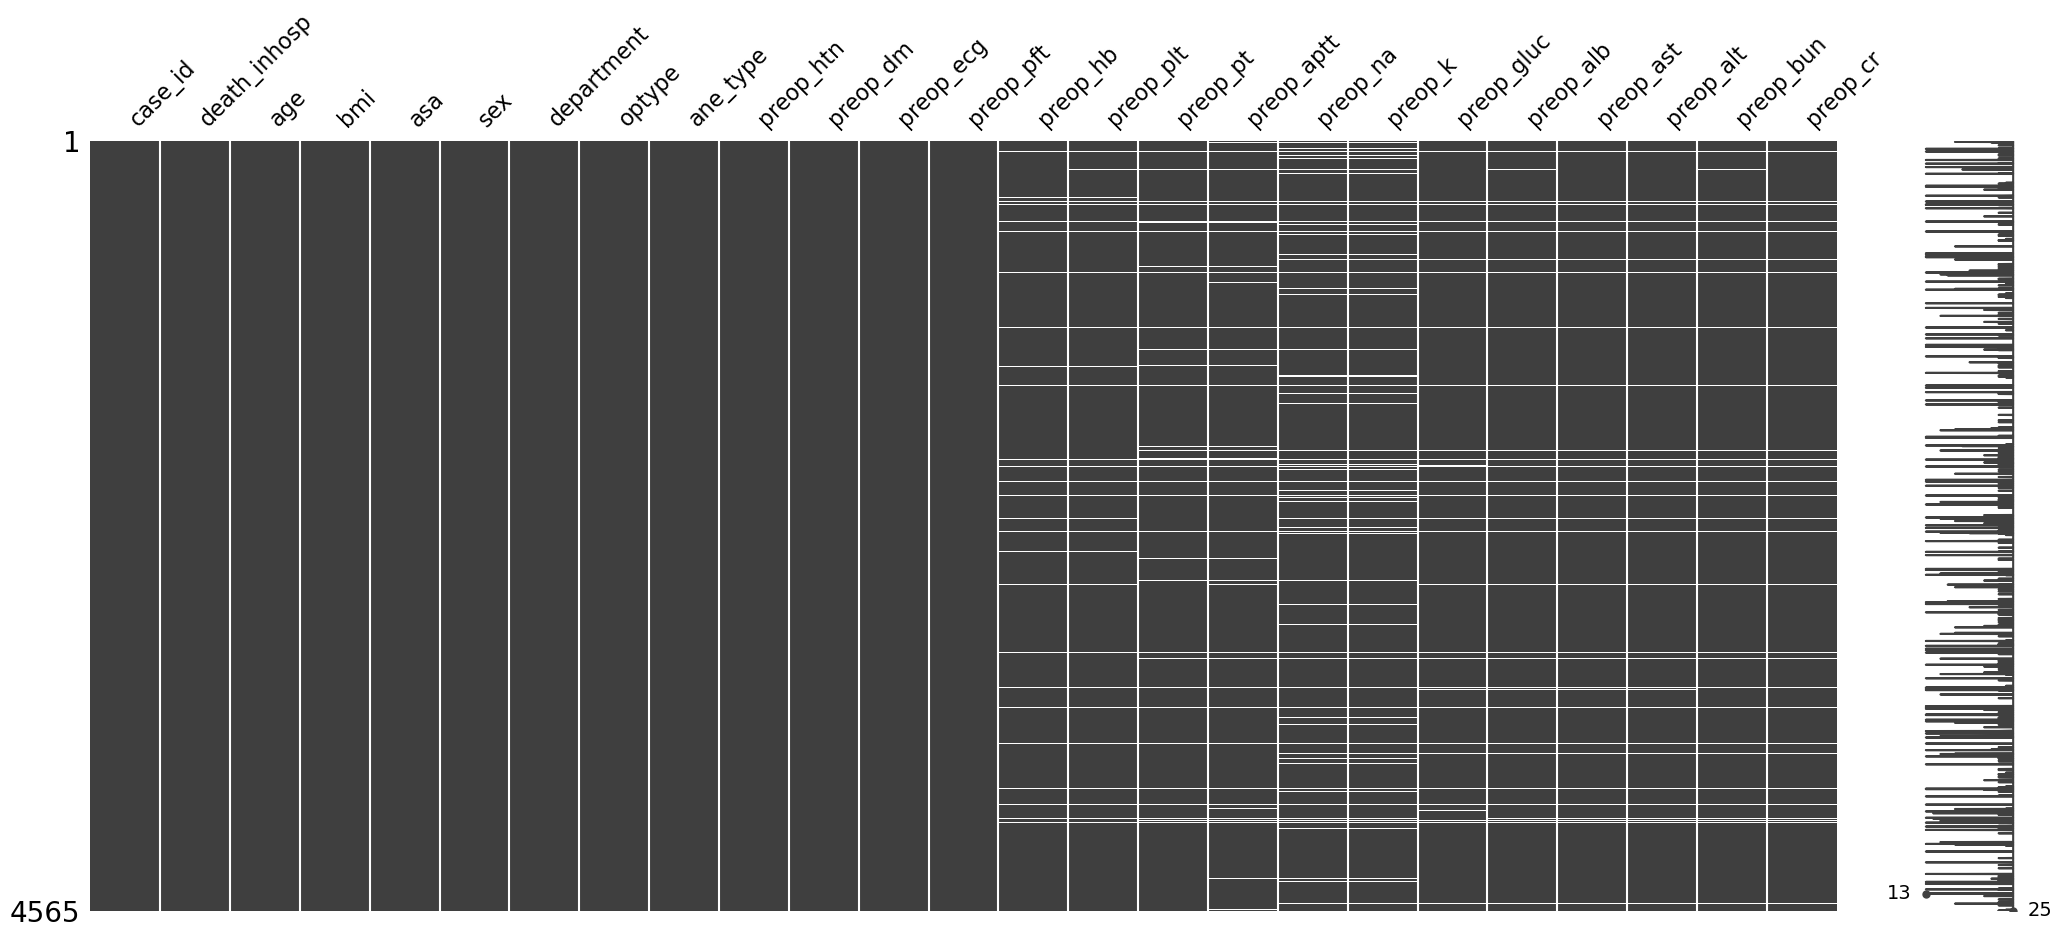

In [16]:

#it has been noticed that data has been missing from any column in the data.

import missingno

missingno.matrix(final_preop_cases)

In [17]:
print(final_preop_cases.shape)
final_preop_cases.isnull().sum()

(4565, 25)


case_id           0
death_inhosp      0
age               0
bmi               0
asa               0
sex               0
department        0
optype            0
ane_type          0
preop_htn         0
preop_dm          0
preop_ecg         0
preop_pft         0
preop_hb        134
preop_plt       136
preop_pt        173
preop_aptt      183
preop_na        333
preop_k         332
preop_gluc      160
preop_alb       146
preop_ast       142
preop_alt       143
preop_bun       146
preop_cr        145
dtype: int64

In [18]:
columns_to_impute_mean= ['preop_plt','preop_hb', 'preop_k']
final_preop_cases[columns_to_impute_mean] = final_preop_cases[columns_to_impute_mean].fillna(df[columns_to_impute_mean].mean())
final_preop_cases[columns_to_impute_mean]=final_preop_cases[columns_to_impute_mean].round(2)


In [19]:
columns_to_impute_median = [ 
       'preop_pt', 'preop_na','preop_gluc', 'preop_ast', 'preop_alt', 'preop_bun','preop_aptt','preop_alb','preop_cr']

final_preop_cases[columns_to_impute_median] = final_preop_cases[columns_to_impute_median].fillna(df[columns_to_impute_median].median().round(2))
final_preop_cases[columns_to_impute_median]=final_preop_cases[columns_to_impute_median].round(2)



In [20]:
final_preop_cases.isnull().sum()

case_id         0
death_inhosp    0
age             0
bmi             0
asa             0
sex             0
department      0
optype          0
ane_type        0
preop_htn       0
preop_dm        0
preop_ecg       0
preop_pft       0
preop_hb        0
preop_plt       0
preop_pt        0
preop_aptt      0
preop_na        0
preop_k         0
preop_gluc      0
preop_alb       0
preop_ast       0
preop_alt       0
preop_bun       0
preop_cr        0
dtype: int64

<AxesSubplot:>

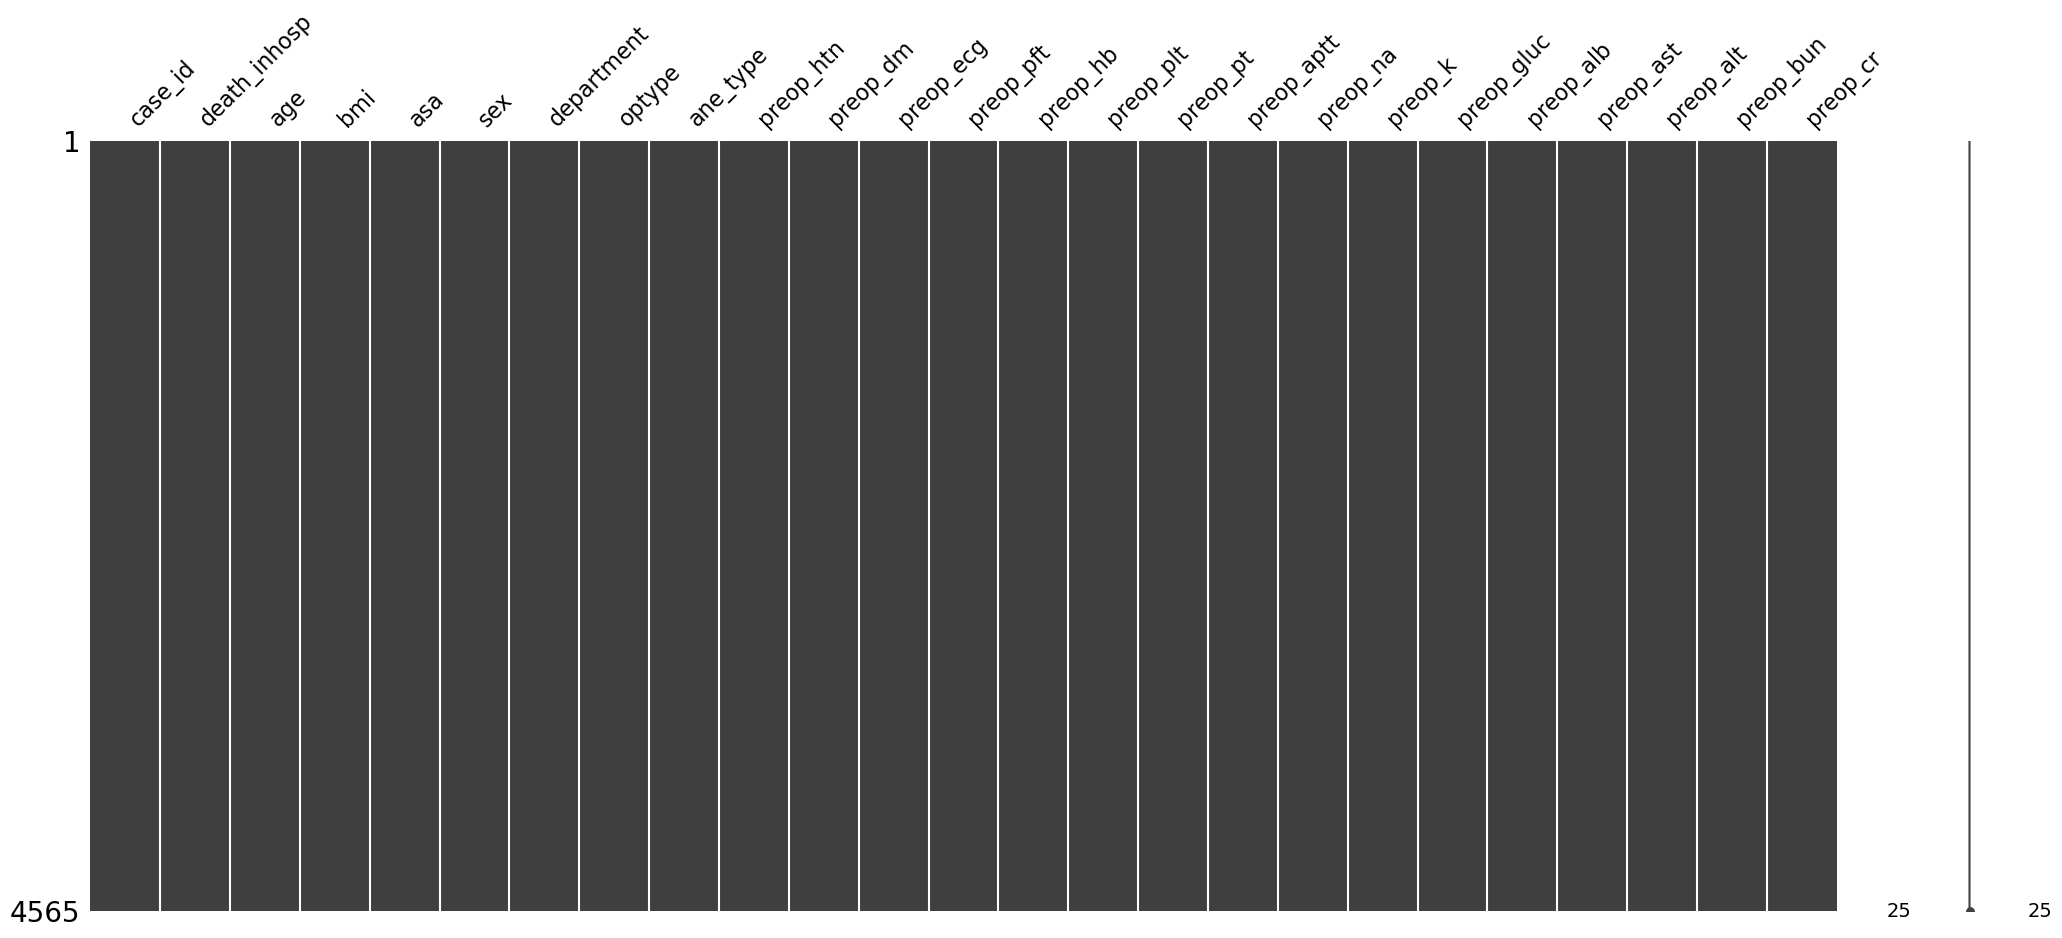

In [21]:
missingno.matrix(final_preop_cases)

In [22]:
#checking unique values
print("Unique Values in 'Gender'", list(final_preop_cases.sex.unique()))
print("Unique Values in 'ASA'", list(final_preop_cases.asa.unique()))
print("Unique Values in 'diabetes'", list(final_preop_cases.preop_dm.unique()))
print("Unique Values in 'hypertension'", list(final_preop_cases.preop_htn.unique()))
print("Unique Values in 'anaesthesia type'", list(final_preop_cases.ane_type.unique()))
print("Unique Values in 'department type'", list(final_preop_cases.department.unique()))
print("Unique Values in 'operation  type'", list(final_preop_cases.optype.unique()))



Unique Values in 'Gender' ['M', 'F']
Unique Values in 'ASA' [2.0, 1.0, 3.0, 4.0]
Unique Values in 'diabetes' [0, 1]
Unique Values in 'hypertension' [1, 0]
Unique Values in 'anaesthesia type' ['General', 'Spinal', 'Sedationalgesia']
Unique Values in 'department type' ['General surgery', 'Urology', 'Thoracic surgery', 'Gynecology']
Unique Values in 'operation  type' ['Colorectal', 'Stomach', 'Biliary/Pancreas', 'Breast', 'Minor resection', 'Hepatic', 'Thyroid', 'Major resection', 'Transplantation', 'Others', 'Vascular']


(array([3752.,    0.,    0.,  112.,    0.,    0.,  515.,    0.,    0.,
         186.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

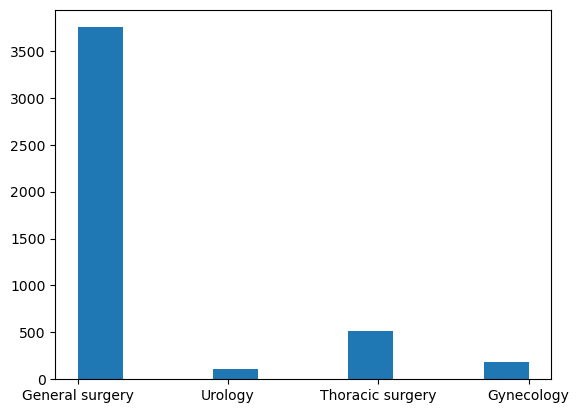

In [23]:
plt.hist(final_preop_cases['department'])

(array([2159.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2406.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

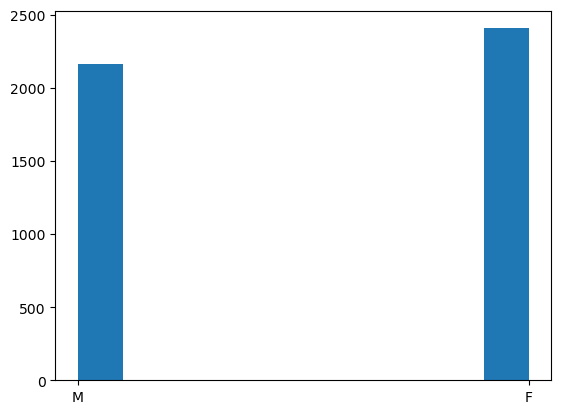

In [24]:
plt.hist(final_preop_cases['sex'])

(array([4315.,    0.,    0.,    0.,    0.,  208.,    0.,    0.,    0.,
          42.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

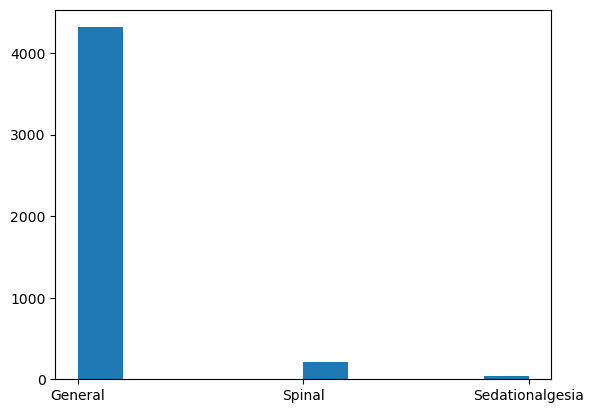

In [25]:
plt.hist(final_preop_cases['ane_type'])


<AxesSubplot:ylabel='Density'>

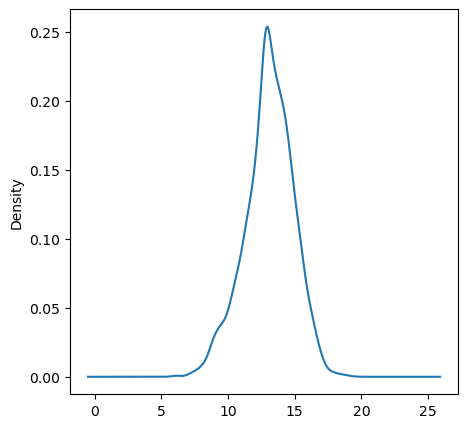

In [26]:
plt.figure(figsize=(5,5))
final_preop_cases['preop_hb'].plot(kind='density')

<AxesSubplot:ylabel='Density'>

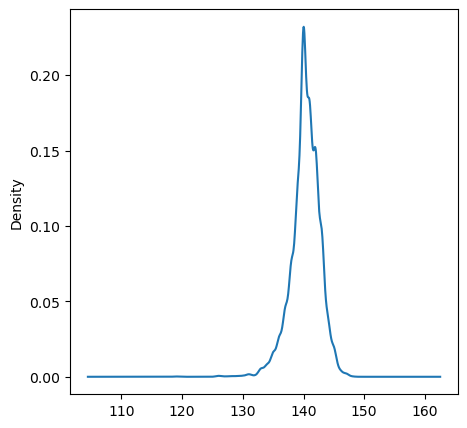

In [27]:
plt.figure(figsize=(5,5))
final_preop_cases['preop_na'].plot(kind='density')

In [28]:
# to all numeric
cat_cols=final_preop_cases.select_dtypes(include=['object']).columns
num_cols = final_preop_cases.select_dtypes(include=np.number).columns.tolist()
print("Categorical Variables:")
print(cat_cols)
print("Numerical Variables:")
print(num_cols)



Categorical Variables:
Index(['sex', 'department', 'optype', 'ane_type', 'preop_ecg', 'preop_pft'], dtype='object')
Numerical Variables:
['case_id', 'death_inhosp', 'age', 'bmi', 'asa', 'preop_htn', 'preop_dm', 'preop_hb', 'preop_plt', 'preop_pt', 'preop_aptt', 'preop_na', 'preop_k', 'preop_gluc', 'preop_alb', 'preop_ast', 'preop_alt', 'preop_bun', 'preop_cr']


# label encoding

In [29]:
cols = ['sex', 'department', 'optype', 'ane_type', 'preop_ecg', 'preop_pft']
#
# Encode labels of multiple columns at once
#
final_preop_cases[cols] = final_preop_cases[cols].apply(LabelEncoder().fit_transform)
#
# Print head
#
final_preop_cases.head()



,case_id,death_inhosp,age,bmi,asa,sex,department,optype,ane_type,preop_htn,preop_dm,preop_ecg,preop_pft,preop_hb,preop_plt,preop_pt,preop_aptt,preop_na,preop_k,preop_gluc,preop_alb,preop_ast,preop_alt,preop_bun,preop_cr
0,1,0,77,26.3,2.0,1,0,2,0,1,0,10,6,14.1,189.0,94.0,33.2,141.0,3.1,134.0,4.3,18.0,16.0,10.0,0.82
1,2,0,54,19.6,2.0,1,0,7,0,0,0,10,6,10.2,251.0,110.0,31.9,143.0,4.7,88.0,3.8,18.0,15.0,14.0,0.86
2,3,0,62,24.4,1.0,1,0,0,0,0,0,10,6,14.2,373.0,103.0,30.3,144.0,4.9,87.0,4.2,17.0,34.0,14.0,1.18
7,8,0,81,27.4,2.0,0,0,1,0,0,0,10,6,12.1,186.0,92.0,31.3,142.0,4.5,101.0,3.7,16.0,10.0,11.0,0.69
8,9,0,32,20.4,1.0,0,0,0,0,0,0,10,6,13.7,141.0,96.0,32.1,140.0,4.2,91.0,4.5,14.0,11.0,8.0,0.58


In [30]:
print(final_preop_cases.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4565 entries, 0 to 6387
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   case_id       4565 non-null   int64  
 1   death_inhosp  4565 non-null   int64  
 2   age           4565 non-null   int32  
 3   bmi           4565 non-null   float64
 4   asa           4565 non-null   float64
 5   sex           4565 non-null   int32  
 6   department    4565 non-null   int32  
 7   optype        4565 non-null   int32  
 8   ane_type      4565 non-null   int32  
 9   preop_htn     4565 non-null   int64  
 10  preop_dm      4565 non-null   int64  
 11  preop_ecg     4565 non-null   int32  
 12  preop_pft     4565 non-null   int32  
 13  preop_hb      4565 non-null   float64
 14  preop_plt     4565 non-null   float64
 15  preop_pt      4565 non-null   float64
 16  preop_aptt    4565 non-null   float64
 17  preop_na      4565 non-null   float64
 18  preop_k       4565 non-null 

In [31]:
final_preop_cases['asa'] = final_preop_cases['asa'].astype(int)  # cast data type to int


In [32]:
final_preop_cases[['preop_hb', 'preop_plt', 'preop_pt', 
                   'preop_aptt', 'preop_na', 'preop_k', 
                   'preop_gluc', 'preop_alb', 'preop_ast', 'preop_alt', 
                   'preop_bun', 'preop_cr','bmi']] = final_preop_cases[['preop_hb', 'preop_plt', 'preop_pt', 
                   'preop_aptt', 'preop_na', 'preop_k', 
                   'preop_gluc', 'preop_alb', 'preop_ast', 'preop_alt', 
                   'preop_bun', 'preop_cr','bmi']].round(3)

In [33]:
print(final_preop_cases[['preop_hb','preop_cr']])

      preop_hb  preop_cr
0         14.1      0.82
1         10.2      0.86
2         14.2      1.18
7         12.1      0.69
8         13.7      0.58
...        ...       ...
6383      14.5      0.99
6384      15.2      0.84
6385      12.6      0.66
6386      12.5      0.65
6387       8.6      0.64

[4565 rows x 2 columns]


In [34]:
final_preop_cases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4565 entries, 0 to 6387
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   case_id       4565 non-null   int64  
 1   death_inhosp  4565 non-null   int64  
 2   age           4565 non-null   int32  
 3   bmi           4565 non-null   float64
 4   asa           4565 non-null   int32  
 5   sex           4565 non-null   int32  
 6   department    4565 non-null   int32  
 7   optype        4565 non-null   int32  
 8   ane_type      4565 non-null   int32  
 9   preop_htn     4565 non-null   int64  
 10  preop_dm      4565 non-null   int64  
 11  preop_ecg     4565 non-null   int32  
 12  preop_pft     4565 non-null   int32  
 13  preop_hb      4565 non-null   float64
 14  preop_plt     4565 non-null   float64
 15  preop_pt      4565 non-null   float64
 16  preop_aptt    4565 non-null   float64
 17  preop_na      4565 non-null   float64
 18  preop_k       4565 non-null 

0    4547
1      18
Name: death_inhosp, dtype: int64

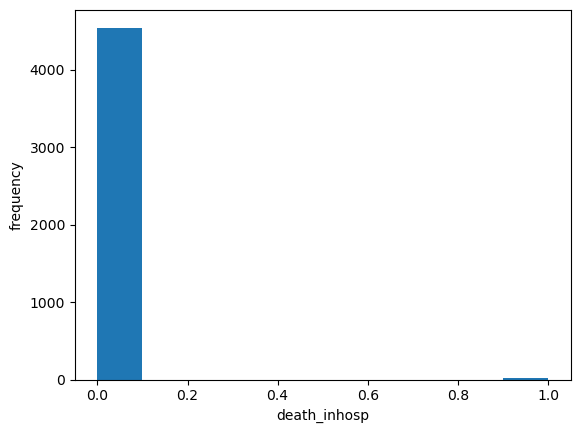

In [35]:
#unbalanced data plot histogram
plt.hist(final_preop_cases['death_inhosp' ])
plt.xlabel('death_inhosp')
plt.ylabel('frequency')                                                               
final_preop_cases['death_inhosp'].value_counts()

# features and labels

In [36]:
X = final_preop_cases.drop(columns=['death_inhosp','case_id','age','sex'],axis=1)
y = final_preop_cases['death_inhosp']

# pca

In [37]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming 'X' contains your 23-dimensional feature data
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce the dimensionality to 15
pca = PCA(n_components=15)
X_pca = pca.fit_transform(X_scaled)

# X_pca now contains the top 15 principal components, which can be considered as the selected top 15 features


# smote

In [38]:
from imblearn.over_sampling import SMOTE

# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_pca, y, test_size=0.3, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Apply SMOTE only to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Now, you have balanced training data in X_train_resampled, y_train_resampled,
# and validation/test sets in X_validation, X_test, y_validation, y_test


In [39]:
print(X_train_resampled.shape)

(6366, 15)


0    4547
1      18
Name: death_inhosp, dtype: int64

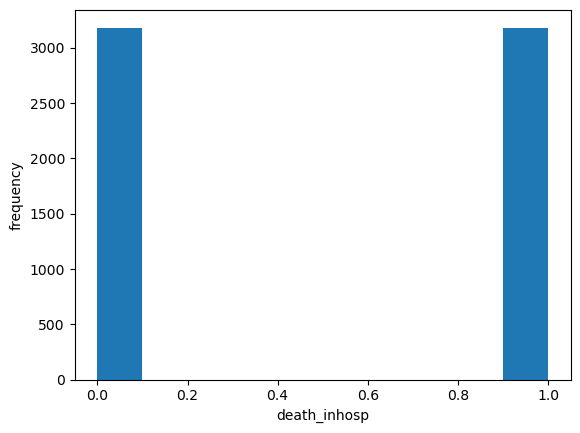

In [40]:
#balanced data plot histogram
plt.hist(y_train_resampled)
plt.xlabel('death_inhosp')
plt.ylabel('frequency')                                                               
final_preop_cases['death_inhosp'].value_counts()

In [41]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

In [42]:
X_train_f=sc.fit_transform(X_train_resampled)
X_test_f=sc.transform(X_test)

In [43]:
print(X_train_resampled.shape)

(6366, 15)


# lazypredict

In [44]:
pip install lazypredict

Note: you may need to restart the kernel to use updated packages.


In [45]:
import lazypredict

In [46]:
from lazypredict.Supervised import LazyClassifier

In [47]:

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_f, X_test_f, y_train_resampled, y_test)

print(models)


100%|██████████| 29/29 [00:16<00:00,  1.71it/s]

[LightGBM] [Info] Number of positive: 3183, number of negative: 3183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6366, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreeClassifier                0.97               0.73     0.73      0.98   
NuSVC                              0.85               0.68     0.68      0.92   
CalibratedClassifierCV             0.74               0.62     0.62      0.85   
LogisticRegression                 0.74               0.62     0.62      0.85   
LinearSVC                          0.73               0.62     0.62      0.84 

# ExtraTreeClassifier

# hyperparameter tuning

In [48]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import ExtraTreeClassifier
from sklearn.metrics import accuracy_score

# Create the ExtraTreeClassifier
extra_tree_model = ExtraTreeClassifier(random_state=42)

# Define hyperparameters for tuning
param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create GridSearchCV instance
grid_search = GridSearchCV(extra_tree_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model on the training data
grid_search.fit(X_train_f, y_train_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(best_params)
# Train the ExtraTreeClassifier with the best hyperparameters on the combined train and validation sets
best_extra_tree_model = ExtraTreeClassifier(**best_params, random_state=42)
best_extra_tree_model.fit(np.concatenate((X_train_f, X_validation)), np.concatenate((y_train_resampled, y_validation)))

# Make predictions on the test set
predictions_test = best_extra_tree_model.predict(X_test_f)

# Make predictions on the validation set
y_pred_val =best_extra_tree_model.predict(X_validation)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, predictions_test)
print(f"Test Accuracy: {accuracy_test}")



# Measure accuracy on the validation set
val_accuracy = accuracy_score(y_validation, y_pred_val)
print("Validation Accuracy with Hyperparameter Tuning:", val_accuracy)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test Accuracy: 0.9693430656934306
Validation Accuracy with Hyperparameter Tuning: 1.0


In [50]:
from sklearn.metrics import confusion_matrix, classification_report


# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions_test)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, predictions_test)
print("Classification Report:")
print(class_report)


Confusion Matrix:
[[664  19]
 [  2   0]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       683
           1       0.00      0.00      0.00         2

    accuracy                           0.97       685
   macro avg       0.50      0.49      0.49       685
weighted avg       0.99      0.97      0.98       685

